# Demos: Lecture 15

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Demo 1: VQE for the deuteron (solution)

Below is a Hamiltonian for a _real_ physical system: a deuteron. The ground state of this Hamiltonian is a linear combination of 4 basis states with *real-valued* coefficients, i.e.,

$$
|\psi_g\rangle = a |1000\rangle + b|0100\rangle + c |0010\rangle + d |0001\rangle
$$

**Exercise**: Implement the VQE to find the ground state energy of this Hamiltonian.

*Hint*: To create a suitable ansatz circuit, try generalizing the one from the previous demo.

In [2]:
coeffs = [28.657, 0.218, -6.125, -9.625, -13.125, -2.143, -3.913, -5.671, -2.143, -3.913, -5.671]

ops = [
    qml.Identity(0), 
    qml.PauliZ(0),
    qml.PauliZ(1),
    qml.PauliZ(2),
    qml.PauliZ(3),
    qml.PauliX(0) @ qml.PauliX(1),
    qml.PauliX(1) @ qml.PauliX(2),
    qml.PauliX(2) @ qml.PauliX(3),
    qml.PauliY(0) @ qml.PauliY(1),
    qml.PauliY(1) @ qml.PauliY(2),
    qml.PauliY(2) @ qml.PauliY(3)
]

H = qml.Hamiltonian(coeffs, ops)

In [6]:
print(H)

  (-13.125) [Z3]
+ (-9.625) [Z2]
+ (-6.125) [Z1]
+ (0.218) [Z0]
+ (28.657) [I0]
+ (-5.671) [X2 X3]
+ (-5.671) [Y2 Y3]
+ (-3.913) [X1 X2]
+ (-3.913) [Y1 Y2]
+ (-2.143) [X0 X1]
+ (-2.143) [Y0 Y1]


In [3]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def ansatz(params):
    # |0000> -> a|1000> + b|0100> + c|0010> + d|0001>
    
    # |0000> -> a|0000> + b|1000>
    # X_0 |0000> -> |1000>
    qml.PauliX(wires=0)
    
    # RY_1 |1000> -> a |1000> + b |1100>
    # CNOT (RY_1) |1000> -> a|1000> + b|0100>
    qml.RY(params[0], wires=1)
    qml.CNOT(wires=[1, 0])
    
    # a|1000> + b|0100> -> a|1000> + b|0100> + c|0110>
    qml.CRY(params[1], wires=[1, 2])
    # a|1000> + b|0100> + c|0110> -> a|1000> + b|0100> + c|0010> 
    qml.CNOT(wires=[2, 1])
    
    # a|1000> + b|0100> + c|0010> -> a|1000> + b|0100> + c|0010> + d|0001>
    qml.CRY(params[2], wires=[2, 3])
    qml.CNOT(wires=[3, 2])
    
    return qml.expval(H)

In [5]:
print(qml.draw(ansatz)([0.1, 0.2, 0.3]))

0: ──X────────╭X───────────────────────────┤ ╭<𝓗>
1: ──RY(0.10)─╰●─╭●────────╭X──────────────┤ ├<𝓗>
2: ──────────────╰RY(0.20)─╰●─╭●────────╭X─┤ ├<𝓗>
3: ───────────────────────────╰RY(0.30)─╰●─┤ ╰<𝓗>


In [12]:
opt = qml.GradientDescentOptimizer()

n_its = 300
params = np.random.uniform(size=3)
energies = []

for _ in range(n_its):
    params, _energy = opt.step_and_cost(ansatz, params)
    energies.append(_energy)

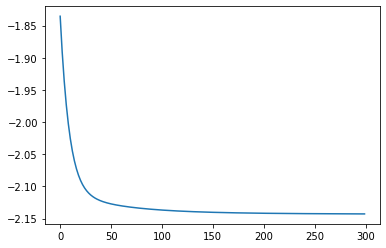

In [13]:
plt.plot(energies)

In [14]:
energies[-1]

array(-2.14263965)

In [15]:
params

tensor([0.83848692, 0.93224624, 0.79975062], requires_grad=True)

In [17]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def ansatz(params):
    qml.PauliX(wires=0)
    
    qml.RY(params[0], wires=1)
    qml.CNOT(wires=[1, 0])
    
    qml.CRY(params[1], wires=[1, 2])
    qml.CNOT(wires=[2, 1])
    
    qml.CRY(params[2], wires=[2, 3])
    qml.CNOT(wires=[3, 2])
    
    return qml.state()

In [18]:
ansatz(params)

/home/olivia/Code/pennylane/pennylane/qnode.py:823: UserWarning: The device was switched during the call of the QNode, to avoid this behaviour definean interface argument instead of auto.
  warnings.warn(


tensor([0.        +0.j, 0.07122222+0.j, 0.16851496+0.j, 0.        +0.j,
        0.3636423 +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.91339717+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j], requires_grad=True)